**Вардумян А.Т. ИУ5-61Б**

<a id='0'></a>
# Оглавление

2. [Задание](#1)<br>
3. [Описание датасета](#2)<br>
4. [Импорт библиотек](#3)<br>
5. [Загрузка и первичный анализ данных](#4)<br>
6. [Построение модели](#5)<br>
7. [Сравнение моделей](#6)<br>

<a id="1"></a>
# Задание ([к оглавлению](#0))

1. Выберите набор данных (датасет) для решения задачи классификации или регресии.

2. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.

3. С использованием метода train_test_split разделите выборку на обучающую и тестовую.

4. Обучите следующие ансамблевые модели:

    * одну из моделей группы бэггинга (бэггинг или случайный лес или сверхслучайные деревья);
    * одну из моделей группы бустинга;
    * одну из моделей группы стекинга.

5. Оцените качество моделей с помощью одной из подходящих для задачи метрик. Сравните качество полученных моделей.

<a id="2"></a>
# Описание датасета ([к оглавлению](#0))

Digital payments are evolving, but so are cyber criminals.

According to the Data Breach Index, more than 5 million records are being stolen on a daily basis, a concerning statistic that shows - fraud is still very common both for Card-Present and Card-not Present type of payments.

In today’s digital world where trillions of Card transaction happens per day, detection of fraud is challenging.


This Dataset sourced by some unnamed institute.

---

**Feature Explanation:**

`distancefromhome` - the distance from home where the transaction happened.

`distancefromlast_transaction` - the distance from last transaction happened.

`ratiotomedianpurchaseprice` - Ratio of purchased price transaction to median purchase price.

`repeat_retailer` - Is the transaction happened from same retailer.

`used_chip` - Is the transaction through chip (credit card).

`usedpinnumber` - Is the transaction happened by using PIN number.

`online_order` - Is the transaction an online order.

`fraud` - Is the transaction fraudulent.

<a id="3"></a>
# Импорт библиотек ([к оглавлению](#0))

In [81]:
import numpy as np
import pandas as pd

from io import StringIO 
import graphviz
import pydotplus
from IPython.core.display import HTML, Image
from operator import itemgetter
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier

from sklearn.pipeline import Pipeline

from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

<a id="4"></a>
# Загрузка и первичный анализ данных ([к оглавлению](#0))

## Первичный анализ

In [2]:
df = pd.read_csv("../datasets/card_transdata.csv")
df = df.head(100000)
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   distance_from_home              100000 non-null  float64
 1   distance_from_last_transaction  100000 non-null  float64
 2   ratio_to_median_purchase_price  100000 non-null  float64
 3   repeat_retailer                 100000 non-null  float64
 4   used_chip                       100000 non-null  float64
 5   used_pin_number                 100000 non-null  float64
 6   online_order                    100000 non-null  float64
 7   fraud                           100000 non-null  float64
dtypes: float64(8)
memory usage: 6.1 MB


In [4]:
df = df.rename(columns={
    "distance_from_home": "dist_home",
    "distance_from_last_transaction": "dist_last",
    "ratio_to_median_purchase_price": "ratio",
    "repeat_retailer": "repeat",
    "used_chip": "chip",
    "used_pin_number": "pin",
    "online_order": "online"
})
df.head()

,dist_home,dist_last,ratio,repeat,chip,pin,online,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [5]:
cat_features = [
    "repeat",
    "chip",
    "pin",
    "online"
]

num_features = [
    "dist_home",
    "dist_last",
    "ratio"
]

target_feature = "fraud"
df[target_feature] = df[target_feature].astype(int)

for feat in cat_features:
    df[feat] = df[feat].astype(int)

df.head()

,dist_home,dist_last,ratio,repeat,chip,pin,online,fraud
0,57.877857,0.311140,1.945940,1,1,0,0,0
1,10.829943,0.175592,1.294219,1,0,0,0,0
2,5.091079,0.805153,0.427715,1,0,0,1,0
3,2.247564,5.600044,0.362663,1,1,0,1,0
4,44.190936,0.566486,2.222767,1,1,0,1,0


In [6]:
df.describe()

,dist_home,dist_last,ratio,repeat,chip,pin,online,fraud
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,26.688487,5.023716,1.819374,0.882090,0.351060,0.103250,0.650660,0.087100
std,65.132078,24.439420,2.912849,0.322503,0.477304,0.304287,0.476764,0.281983
min,0.021322,0.000488,0.011373,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.864892,0.295815,0.476392,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.965281,0.996695,0.996081,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.726777,3.333064,2.089016,1.000000,1.000000,0.000000,1.000000,0.000000
max,4601.011222,2160.499922,266.689692,1.000000,1.000000,1.000000,1.000000,1.000000


## Корреляционный анализ

In [7]:
corr = df.corr()
corr

,dist_home,dist_last,ratio,repeat,chip,pin,online,fraud
dist_home,1.000000,-0.002562,-0.000656,0.143589,-0.002928,0.002518,-0.000250,0.187143
dist_last,-0.002562,1.000000,0.000531,-0.006873,0.000284,0.001851,-0.001003,0.097031
ratio,-0.000656,0.000531,1.000000,-0.001365,-0.000684,0.001522,0.002817,0.441085
repeat,0.143589,-0.006873,-0.001365,1.000000,-0.002641,-0.002301,0.003508,-0.002200
chip,-0.002928,0.000284,-0.000684,-0.002641,1.000000,-0.000048,-0.001629,-0.062392
pin,0.002518,0.001851,0.001522,-0.002301,-0.000048,1.000000,0.000616,-0.101431
online,-0.000250,-0.001003,0.002817,0.003508,-0.001629,0.000616,1.000000,0.192710
fraud,0.187143,0.097031,0.441085,-0.002200,-0.062392,-0.101431,0.192710,1.000000


In [8]:
corr[target_feature]

dist_home    0.187143
dist_last    0.097031
ratio        0.441085
repeat      -0.002200
chip        -0.062392
pin         -0.101431
online       0.192710
fraud        1.000000
Name: fraud, dtype: float64

<AxesSubplot:>

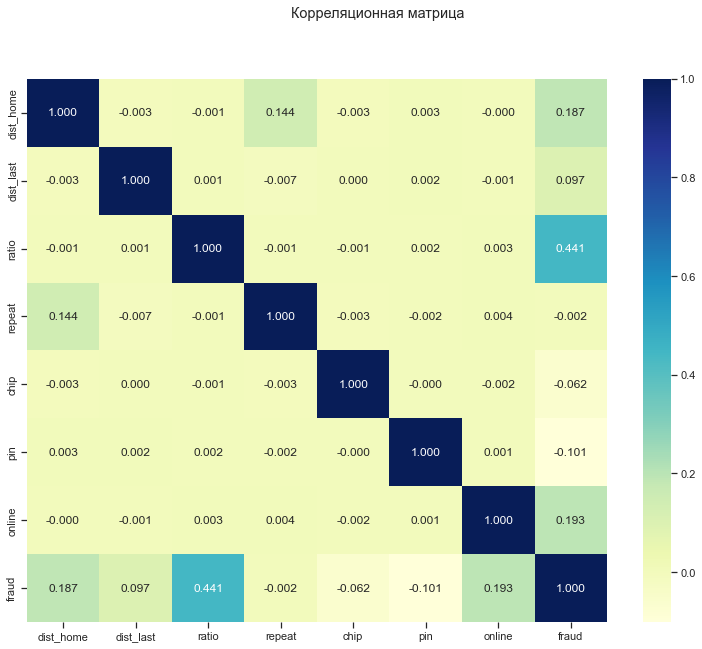

In [9]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(13,10))
fig.suptitle('Корреляционная матрица')
sns.heatmap(corr, ax=ax, annot=True, fmt='.3f', cmap='YlGnBu')

<a id="5"></a>
# Построение модели ([к оглавлению](#0))

## Разделение выборки

In [10]:
# Отрисовка ROC-кривой
def draw_roc_curve(y_true, y_score, pos_label, average):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [11]:
# Тестовая и обучающая выборки
X = df.loc[:, df.columns != target_feature]
y = df[target_feature]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [12]:
preprocess = ColumnTransformer([('continuous', StandardScaler(), num_features),
                               ('categorial', OrdinalEncoder(), cat_features)])

X_train_preprocessed = preprocess.fit_transform(X_train)
X_test_preprocessed = preprocess.fit_transform(X_test)

## Бэггинг с деревьями решений

In [31]:
%%time
bagg_baseline = BaggingClassifier()
bagg_baseline.fit(X_train, y_train)

CPU times: user 871 ms, sys: 17.6 ms, total: 888 ms
Wall time: 894 ms


BaggingClassifier()

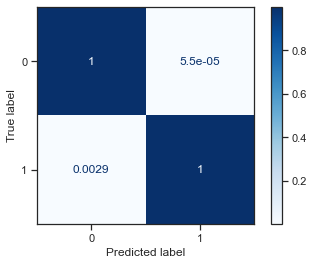

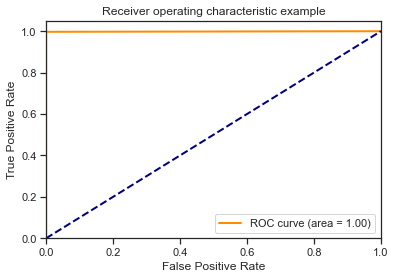

(0.9994246260069045, 0.9971297359357061)

In [249]:
predict = bagg_baseline.predict(X_test)

plot_confusion_matrix(bagg_baseline, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
draw_roc_curve(y_test, predict, pos_label=1, average='micro')
precision_score(y_test, predict), recall_score(y_test, predict)

## Градиентный бустинг

In [39]:
%%time
boost_baseline = GradientBoostingClassifier()
boost_baseline.fit(X_train, y_train)

CPU times: user 9.35 s, sys: 128 ms, total: 9.48 s
Wall time: 9.56 s


GradientBoostingClassifier()

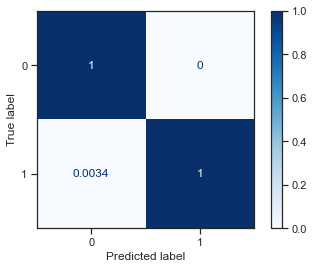

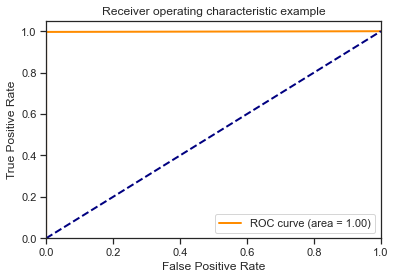

(1.0, 0.9965556831228473)

In [251]:
predict = boost_baseline.predict(X_test)

plot_confusion_matrix(boost_baseline, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
draw_roc_curve(y_test, predict, pos_label=1, average='micro')
precision_score(y_test, predict), recall_score(y_test, predict)

## Стекинг

In [13]:
import sys
!{sys.executable} -m pip install heamy

  Created wheel for heamy: filename=heamy-0.0.7-py2.py3-none-any.whl size=15366 sha256=9c8bcf3bcc172c29451ae7a6218637eaaa18e2119cb198c06da0732f0f2da18b
  Stored in directory: /Users/arsenvardumyan/Library/Caches/pip/wheels/8b/45/dd/8ff1625c56b8bc7e9596c9d6d16b8d50cdffbb06f5b63bf3e9
Successfully built heamy


In [67]:
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline
from heamy.dataset import Dataset

In [68]:
dataset = Dataset(X_train_preprocessed, y_train, X_test_preprocessed)

In [74]:
model_tree = Classifier(dataset=dataset, estimator=DecisionTreeClassifier, name='tree')
model_lr = Classifier(dataset=dataset, estimator=LogisticRegression, name='lr')
model_rf = Classifier(dataset=dataset, estimator=RandomForestClassifier, parameters={'n_estimators': 50},name='rf')

### Эксперимент 1

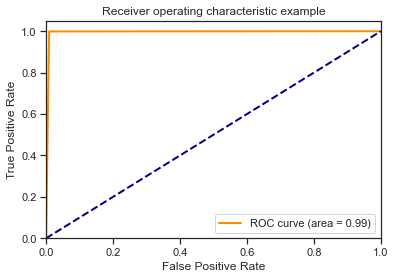

(0.9119496855345912, 0.9988518943742825)

In [108]:
# Эксперимент 1
pipeline = ModelsPipeline(model_tree, model_lr)
stack_ds = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker = Classifier(dataset=stack_ds, estimator=DecisionTreeClassifier)
predict = stacker.predict()
draw_roc_curve(y_test, predict, pos_label=1, average='micro')
precision_score(y_test, predict), recall_score(y_test, predict)

### Эксперимент 2

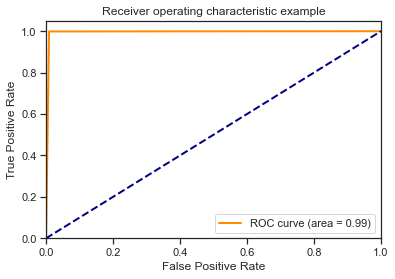

(0.9138655462184874, 0.9988518943742825)

In [119]:
pipeline = ModelsPipeline(model_tree, model_lr, model_rf)
stack_ds3 = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker = Classifier(dataset=stack_ds3, estimator=DecisionTreeClassifier)
predict = stacker.predict()
draw_roc_curve(y_test, predict, pos_label=1, average='micro')
precision_score(y_test, predict), recall_score(y_test, predict)

<a id="6"></a>
# Сравнение моделей ([к оглавлению](#0))

|Метрика|Бэггинг|Бустинг|Стекинг1|Стекинг2|
| :- | :-: | :-: | :-: | :-: |
|Recall|0.997|0.997|0.999| 0.999 |
|Precision|0.999|1.00|0.912| 0.914 |
|AUC|1.00|1.00|1.00| 0.99 | 0.99 |